# Perturbing initial conditions in the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinAnalysis import *

In [6]:
ls = [6, 7, 8, 9, 10]

In [7]:
data_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    data_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        } )

In [8]:
source_path = "/home/florianb/havvarsel/multilevelDA/scripts/VarianceLevels/Basin/2023-05-05T14_03_12"

In [9]:
vars_list = []
diff_vars_list = []
for f in os.listdir(source_path):
    if f.startswith("diff_vars"):
        diff_vars_list.append( os.path.abspath(os.path.join(source_path, f)) )
    if f.startswith("vars"):
        vars_list.append( os.path.abspath(os.path.join(source_path, f)) ) 

In [10]:
# Sorting by time
vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[1].split(".")[0]) for v in vars_list], vars_list)) ]
diff_vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[2].split(".")[0]) for v in diff_vars_list], diff_vars_list)) ]

In [11]:
np.load(vars_list[1])

array([[1.84971393e-05, 6.83591355e-02, 7.73360557e-02],
       [1.95765564e-05, 7.29322612e-02, 8.20082065e-02],
       [1.91566892e-05, 7.25724599e-02, 8.54843355e-02],
       [1.87763543e-05, 7.38306831e-02, 8.24463400e-02],
       [1.91764790e-05, 7.16453203e-02, 8.55789702e-02]])

In [12]:
np.load(diff_vars_list[1])

array([[9.62375637e-08, 4.29077178e-04, 9.71085516e-04],
       [1.88783174e-08, 1.03528229e-04, 2.41484721e-04],
       [4.39467520e-09, 2.63480065e-05, 6.50642598e-05],
       [1.12560940e-09, 6.32223997e-06, 2.92055043e-05]])

In [13]:
def plotLvlVarTs(source_path, suptitle=None, eta_lim=None, huv_lim=None):

    # Read files
    vars_list = []
    diff_vars_list = []
    for f in os.listdir(source_path):
        if f.startswith("diff_vars"):
            diff_vars_list.append( os.path.abspath(os.path.join(source_path, f)) )
        if f.startswith("vars"):
            vars_list.append( os.path.abspath(os.path.join(source_path, f)) ) 

    # Sort files 
    vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[1].split(".")[0]) for v in vars_list], vars_list)) ]
    diff_vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[2].split(".")[0]) for v in diff_vars_list], diff_vars_list)) ]

    # Plot
    with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        fig.suptitle(suptitle)

        axs[0].set_title("$\eta$", fontsize=15)
        axs[1].set_title("$hu$", fontsize=15)
        axs[2].set_title("$hv$", fontsize=15)

        Nxs = [nx*ny for nx, ny in zip([da["nx"] for da in data_args_list], [da["ny"] for da in data_args_list])]

        for T_idx in range(len(vars_list)):
            vars = np.load(vars_list[T_idx])
            diff_vars = np.load(diff_vars_list[T_idx])

            diff_vars = diff_vars/vars[-1]
            vars = vars/vars[-1]

            for i in range(3):
                axs[i].loglog(Nxs, vars[:,i], label="$|| Var[u^l] ||_{L^2}$", linewidth=3, c="C0", alpha=0.1+0.9*T_idx/len(vars_list))
                axs[i].loglog(Nxs[1:], diff_vars[:,i], label="$|| Var[u^l-u^{l-1}] ||_{L^2}$", linewidth=3, c="C1", alpha=0.1+0.9*T_idx/len(vars_list))
                axs[i].set_xlabel("# grid cells", fontsize=15)

                if T_idx+1 == len(vars_list):
                    handles, labels = axs[i].get_legend_handles_labels()
                    axs[i].legend(handles[-2:], labels[-2:], labelcolor="black", loc=(0.2,0.65), fontsize=15)
                    axs[i].set_xticks(Nxs)
                    axs[i].xaxis.grid(True)


        axs[0].set_ylim((eta_lim,2))
        axs[1].set_ylim((huv_lim,2))
        axs[2].set_ylim((huv_lim,2))




/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


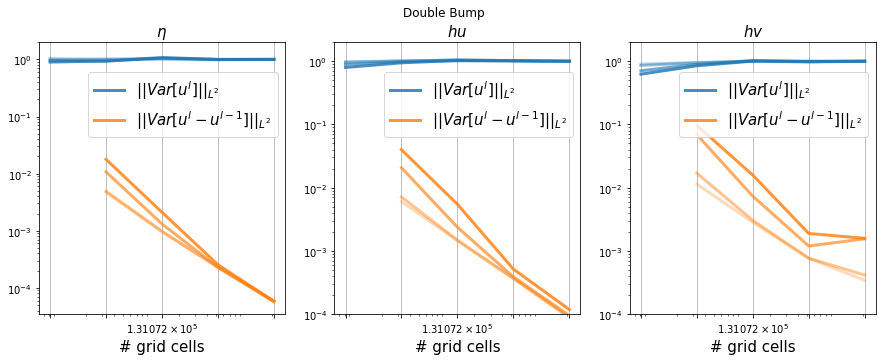

In [18]:
plotLvlVarTs(source_path, suptitle="Double Bump", huv_lim=1e-4)